In [11]:
import kagglehub
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



path = kagglehub.dataset_download("infamouscoder/depression-reddit-cleaned")
print("Path to dataset files:", path)
print('Archivos: ', os.listdir(path=path))

df = pd.read_csv('../DataSets/depression_dataset_reddit_cleaned.csv')

Path to dataset files: /home/jordi/.cache/kagglehub/datasets/infamouscoder/depression-reddit-cleaned/versions/1
Archivos:  []


In [12]:
#df analysis
len(df)
df.head(3)
filas, columns = df.shape
print(f'Cantidad de Filas {filas} -- Cantidad Columnas {columns}')
df.is_depression.unique() #Indicates probable depression boolean 1True 0False
df.isna().sum() #Indicates data is already clean

Cantidad de Filas 7731 -- Cantidad Columnas 2


clean_text       0
is_depression    0
dtype: int64

In [13]:
depression_texts = df[df['is_depression'] == 1]
no_depression_texts = df[df['is_depression'] == 0]

print(depression_texts['clean_text'],'\n')
print('*'*1000)
print('*'*1000)
print('*'*1000)
no_depression_texts['clean_text']

0       we understand that most people who reply immed...
1       welcome to r depression s check in post a plac...
2       anyone else instead of sleeping more when depr...
3       i ve kind of stuffed around a lot in my life d...
4       sleep is my greatest and most comforting escap...
                              ...                        
3826    thlolo march eh it s because i don t want stre...
3827    i hate it when i m having depression day and t...
3828                               educational depression
3829    dmt powder helping with depression amp anxiety...
3830    the great depression money armageddon ep0 http...
Name: clean_text, Length: 3831, dtype: object 

**************************************************************************************************************************************************************************************************************************************************************************************************************************

3831    switchfoot http twitpic com y zl awww that s a...
3832    is upset that he can t update his facebook by ...
3833    kenichan i dived many time for the ball manage...
3834         my whole body feel itchy and like it on fire
3835    nationwideclass no it s not behaving at all i ...
                              ...                        
7726                                         is that snow
7727                   moulin rouge mad me cry once again
7728    trying to shout but can t find people on the list
7729    ughh can t find my red sox hat got ta wear thi...
7730    slept wonderfully finally tried swatching for ...
Name: clean_text, Length: 3900, dtype: object

In [14]:
"""#VerifyCleanTexts
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
words = ''.join(depression_texts['clean_text'])
clean_word = ' '.join([ word for word in words.split()
                      if 'http' not in word
                          and not word.startswith('@')
                          and word != 'RT'
                      ])
string = "hola adios"
wcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=3000,
    height=2500,
).generate(clean_word)

plt.figure(1, figsize=(12,12))
plt.imshow(wcloud)
plt.axis('off')
plt.show()

print(clean_word)"
"""


'#VerifyCleanTexts\nfrom wordcloud import WordCloud, STOPWORDS\nimport matplotlib.pyplot as plt\nwords = \'\'.join(depression_texts[\'clean_text\'])\nclean_word = \' \'.join([ word for word in words.split()\n                      if \'http\' not in word\n                          and not word.startswith(\'@\')\n                          and word != \'RT\'\n                      ])\nstring = "hola adios"\nwcloud = WordCloud(\n    stopwords=STOPWORDS,\n    background_color=\'black\',\n    width=3000,\n    height=2500,\n).generate(clean_word)\n\nplt.figure(1, figsize=(12,12))\nplt.imshow(wcloud)\nplt.axis(\'off\')\nplt.show()\n\nprint(clean_word)"\n'

In [15]:
#de reddit a words
from nltk.corpus import stopwords
nltk.download('stopwords')
#Tokeniazar con nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download('punkt') 
from nltk.stem import WordNetLemmatizer


def tweet_to_words (tweet): # tweet = comentario = será un coment de reddit
    #Acá se filtra el ruido semántico con una expresión regular
    letters_only= re.sub("[^a-zA-Z]", " ", tweet) # Expresión regular que filtra solo el texto nada de números o caracteres especiales
    
    #Acá hacemos tokenización con una forma básica
    words = letters_only.lower().split() # Se genera una LISTA de palabras en minúscula, es una tokenizacion sencilla
    #words = word_tokenize(letters_only.lower()) 

    #Eliminamos la stopwords
    stops = set(stopwords.words("english")) # Eliminamos palabras que no afecten el significado de la oración
    lemmatizer = WordNetLemmatizer()
    meaningful_words =[lemmatizer.lemmatize(w) for w in words if w not in stops]
    #meaningful_words = [w for w in words if not w in stops] # Guardamos las stopwords
    return(" ".join( meaningful_words ))
    
df_ =  df
df["clean_text"] = df['clean_text'].apply(lambda x: tweet_to_words(x))
df['clean_text']
#Se quitan las stopwords, como pronombres, comas, signos, etc



[nltk_data] Downloading package stopwords to /home/jordi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jordi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jordi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0       understand people reply immediately op invitat...
1       welcome r depression check post place take mom...
2       anyone else instead sleeping depressed stay ni...
3       kind stuffed around lot life delaying inevitab...
4       sleep greatest comforting escape whenever wake...
                              ...                        
7726                                                 snow
7727                                 moulin rouge mad cry
7728                        trying shout find people list
7729    ughh find red sox hat got ta wear creepy nick ...
7730    slept wonderfully finally tried swatching new ...
Name: clean_text, Length: 7731, dtype: object

In [16]:
#Implementación Básica de un modelo, modificaremos a: Spacy?
df['clean_text']
df['is_depression']
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
#Concetración de la data en listas

train_clean_message = []
for message in train['clean_text']:
    train_clean_message.append(message)

test_clean_message = []
for message in test['clean_text']:
    test_clean_message.append(message)

In [18]:
#Vectorizamos el dataset

#CountVectorizer va relacionado (en vectorización) a representación en BoW
#Podría no ser el más adecuado para un chatbot con redes neuronales, modelos como TF-IDF dan peso a las palabras
#O también Word Embeddings para capturar un significado profundo
#Posiblemente el mejor sea vectorizar con modelo como Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer="word")
train_features = v.fit_transform(train_clean_message)
test_features = v.transform(test_clean_message)


Accuracy of DecisionTreeClassifieris 0.9004524886877828
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       803
           1       0.89      0.91      0.90       744

    accuracy                           0.90      1547
   macro avg       0.90      0.90      0.90      1547
weighted avg       0.90      0.90      0.90      1547



<Figure size 640x480 with 0 Axes>

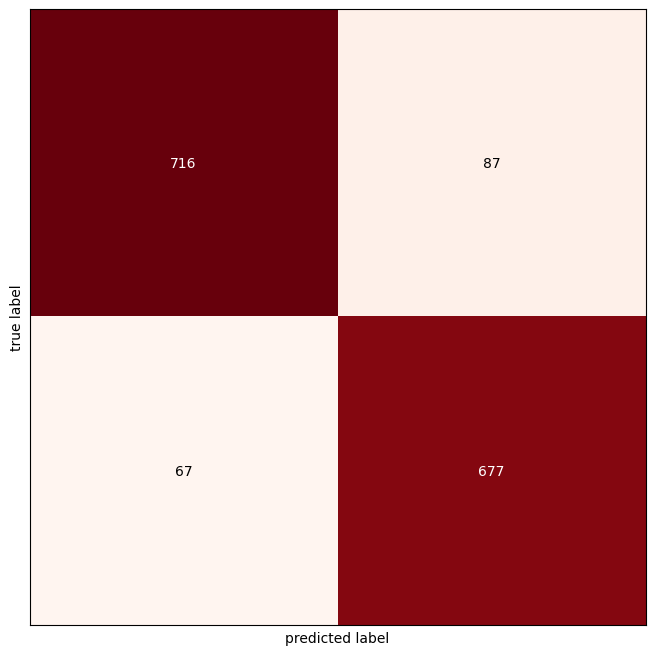

Accuracy of RandomForestClassifieris 0.9463477698771816
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       830
           1       0.91      0.97      0.94       717

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547



<Figure size 640x480 with 0 Axes>

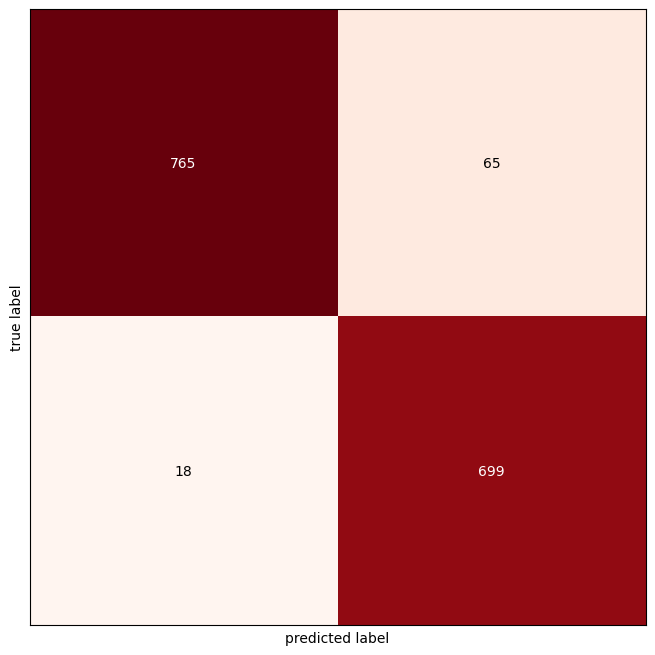

In [19]:
#Acá sería de elegir el modelo, por el momento lo haré con dos básicos
import matplotlib.pyplot as plt
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)
]

dense_features = train_features.toarray()
dense_test = test_features.toarray()

Accuracy = []
Model = []


for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['is_depression'])
        pred = fit.predict(test_features)
    except:
        fit= classifier.fit(dense_features, train['is_depression'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred, test['is_depression'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
    print (classification_report (pred, test['is_depression']))
    cm = confusion_matrix(pred, test['is_depression'])
    plt.figure()
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)
    plt.show()
  
 